In [1]:
import xgboost
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
# Load the data for each model
with open('data/data_a.pkl', 'rb') as file:
    data_a = pickle.load(file)
with open('data/data_b.pkl', 'rb') as file:
    data_b = pickle.load(file)
with open('data/data_c.pkl', 'rb') as file:
    data_c = pickle.load(file)

## Optimized model

In [3]:
def xgb_training(data, max_depth, eta, early_stopping, nfold):
    param_list = {'max_depth':max_depth,
                  'random_state':0,
                  'eval_metric':'error',
                  'eta':eta,
                  'scale_pos_weight':1.0,
                 }
    
    dtrain = xgboost.DMatrix(data['X_train'], label=data['y_train'], feature_names=data['X_train'].columns.values.tolist())
    
    res = xgboost.cv(
    param_list,
    dtrain,
    num_boost_round=10,
    nfold=nfold,
    metrics={"error"},
    seed=0,
    callbacks=[
        # xgboost.callback.EvaluationMonitor(show_stdv=False),
        xgboost.callback.EarlyStopping(early_stopping),
    ],
    )
    return res[-1:].values[0]


In [4]:
early_stopping = 50
nfold = 10
eta = 0.3

In [5]:
result_a = []
result_b = []
result_c = []

for depth in range(3,15):
    result_a.append(xgb_training(data_a, depth, eta, early_stopping, nfold))
    result_b.append(xgb_training(data_b, depth, eta, early_stopping, nfold))
    result_c.append(xgb_training(data_c, depth, eta, early_stopping, nfold))

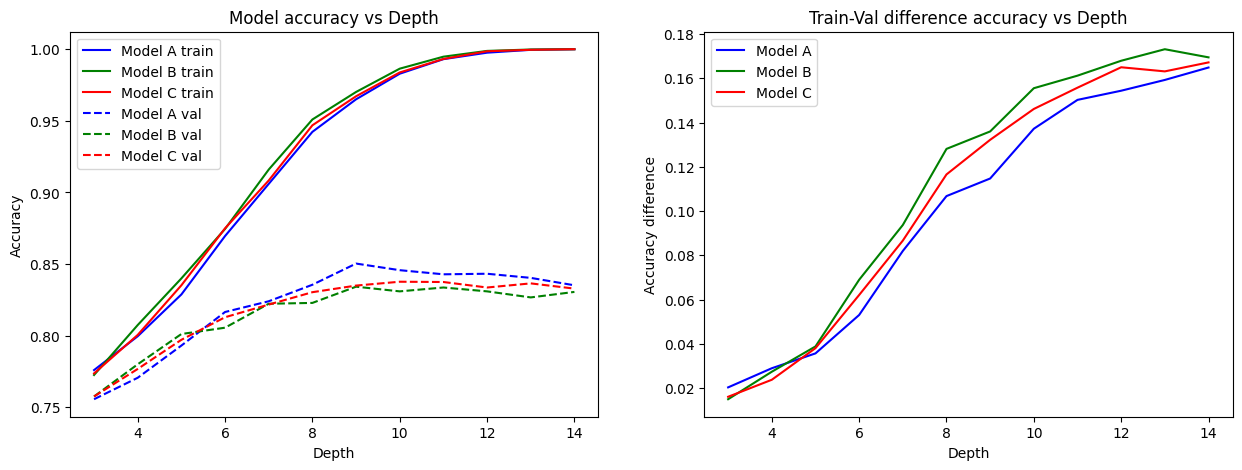

In [6]:
result_a = np.array(result_a)
result_b = np.array(result_b)
result_c = np.array(result_c)

depths = range(3, 15)
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(depths, 1-result_a[:, 0],'b', label='Model A train')
ax[0].plot(depths, 1-result_b[:, 0],'g', label='Model B train')
ax[0].plot(depths, 1-result_c[:, 0],'r', label='Model C train')
ax[0].plot(depths, 1-result_a[:, 2],'b--', label='Model A val')
ax[0].plot(depths, 1-result_b[:, 2],'g--', label='Model B val')
ax[0].plot(depths, 1-result_c[:, 2],'r--', label='Model C val')
ax[0].set_xlabel('Depth')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Model accuracy vs Depth')
ax[0].legend()

ax[1].plot(depths, -result_a[:, 0]+result_a[:,2],'b', label='Model A')
ax[1].plot(depths, -result_b[:, 0]+result_b[:,2],'g', label='Model B')
ax[1].plot(depths, -result_c[:, 0]+result_c[:,2],'r', label='Model C')
ax[1].set_xlabel('Depth')
ax[1].set_ylabel('Accuracy difference')
ax[1].set_title('Train-Val difference accuracy vs Depth')
ax[1].legend()
plt.show()


In [7]:
max_depth =  6
early_stopping = 50
opt_xgb_a = xgboost.XGBClassifier(max_depth=max_depth, eta=eta ,use_label_encoder=False,early_stopping_rounds=early_stopping, eval_metric='error')
opt_xgb_a.fit(data_a['X_train'], data_a['y_train'], eval_set=[(data_a['X_train'], data_a['y_train']), (data_a['X_val'], data_a['y_val'])], verbose=0)
opt_xgb_b = xgboost.XGBClassifier(max_depth=max_depth, eta=eta ,use_label_encoder=False,early_stopping_rounds=early_stopping, eval_metric='error')
opt_xgb_b.fit(data_b['X_train'], data_b['y_train'], eval_set=[(data_b['X_train'], data_b['y_train']), (data_b['X_val'], data_b['y_val'])], verbose=0)
opt_xgb_c = xgboost.XGBClassifier(max_depth=max_depth, eta=eta ,use_label_encoder=False,early_stopping_rounds=early_stopping, eval_metric='error')
opt_xgb_c.fit(data_c['X_train'], data_c['y_train'], eval_set=[(data_c['X_train'], data_c['y_train']), (data_c['X_val'], data_c['y_val'])], verbose=0)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=50,
              enable_categorical=False, eta=0.3, eval_metric='error',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [8]:
# save the models
model_path = 'xgb_models/'
pickle.dump(opt_xgb_a,open(model_path+'opt_XGB_A.pkl','wb'))
pickle.dump(opt_xgb_b,open(model_path+'opt_XGB_B.pkl','wb'))
pickle.dump(opt_xgb_c,open(model_path+'opt_XGB_C.pkl','wb'))

In [9]:
result_a = opt_xgb_a.evals_result()
result_b = opt_xgb_b.evals_result()
result_c = opt_xgb_c.evals_result()

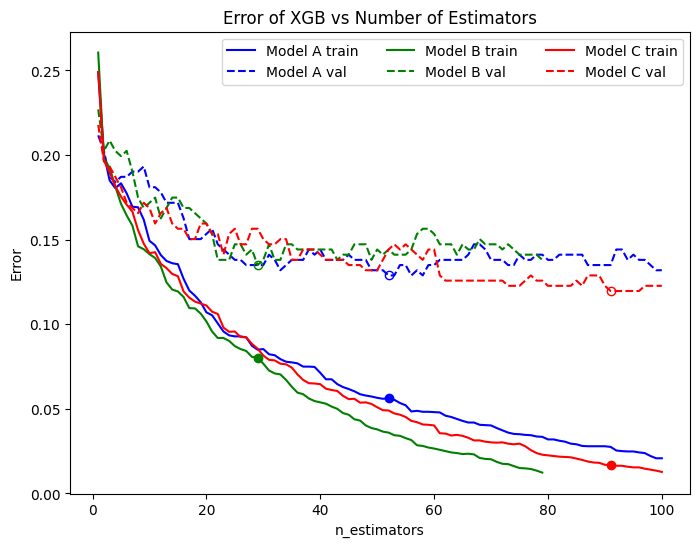

In [10]:
plt.figure(figsize=(8,6))
plt.plot(range(1,1+len(result_a['validation_0']['error'])),result_a['validation_0']['error'],'b',label='Model A train')
plt.plot(range(1,1+len(result_a['validation_1']['error'])),result_a['validation_1']['error'],'b--',label='Model A val')
plt.plot(range(1,1+len(result_b['validation_0']['error'])),result_b['validation_0']['error'],'g',label='Model B train')
plt.plot(range(1,1+len(result_b['validation_1']['error'])),result_b['validation_1']['error'],'g--',label='Model B val')
plt.plot(range(1,1+len(result_c['validation_0']['error'])),result_c['validation_0']['error'],'r',label='Model C train')
plt.plot(range(1,1+len(result_c['validation_1']['error'])),result_c['validation_1']['error'],'r--',label='Model C val')

# Mark best_iteration as a dot
plt.plot(1+opt_xgb_a.best_iteration, result_a['validation_0']['error'][opt_xgb_a.best_iteration], 'bo')
plt.plot(1+opt_xgb_a.best_iteration, result_a['validation_1']['error'][opt_xgb_a.best_iteration], 'bo', markerfacecolor='none')
plt.plot(1+opt_xgb_b.best_iteration, result_b['validation_0']['error'][opt_xgb_b.best_iteration], 'go')
plt.plot(1+opt_xgb_b.best_iteration, result_b['validation_1']['error'][opt_xgb_b.best_iteration], 'go', markerfacecolor='none')
plt.plot(1+opt_xgb_c.best_iteration, result_c['validation_0']['error'][opt_xgb_c.best_iteration], 'ro')
plt.plot(1+opt_xgb_c.best_iteration, result_c['validation_1']['error'][opt_xgb_c.best_iteration], 'ro', markerfacecolor='none')

plt.xlabel('n_estimators')
plt.ylabel('Error')
plt.legend(ncol=3)
plt.title('Error of XGB vs Number of Estimators')
# plt.savefig('opt_XGB_loss.png')
plt.show()


In [11]:
for model_name, xgb, data in zip(['Model A','Model B','Model C'], [opt_xgb_a, opt_xgb_b, opt_xgb_c], [data_a, data_b, data_c]):
    print(model_name)
    print('Training score: %.2f%%' %(xgb.score(data['X_train'], data['y_train'].values) * 100))
    print('Validation score: %.2f%%' %(xgb.score(data['X_val'], data['y_val'].values) * 100))
    print('Testing score: %.2f%%' %(xgb.score(data['X_test'], data['y_test'].values) * 100))
    print('Overall score: %.2f%%\n' %(xgb.score(data['X_all'], data['y'].values) * 100))

Model A
Training score: 94.37%
Validation score: 87.12%
Testing score: 84.21%
Overall score: 92.48%

Model B
Training score: 91.99%
Validation score: 86.50%
Testing score: 82.77%
Overall score: 90.33%

Model C
Training score: 98.33%
Validation score: 88.04%
Testing score: 85.54%
Overall score: 95.90%



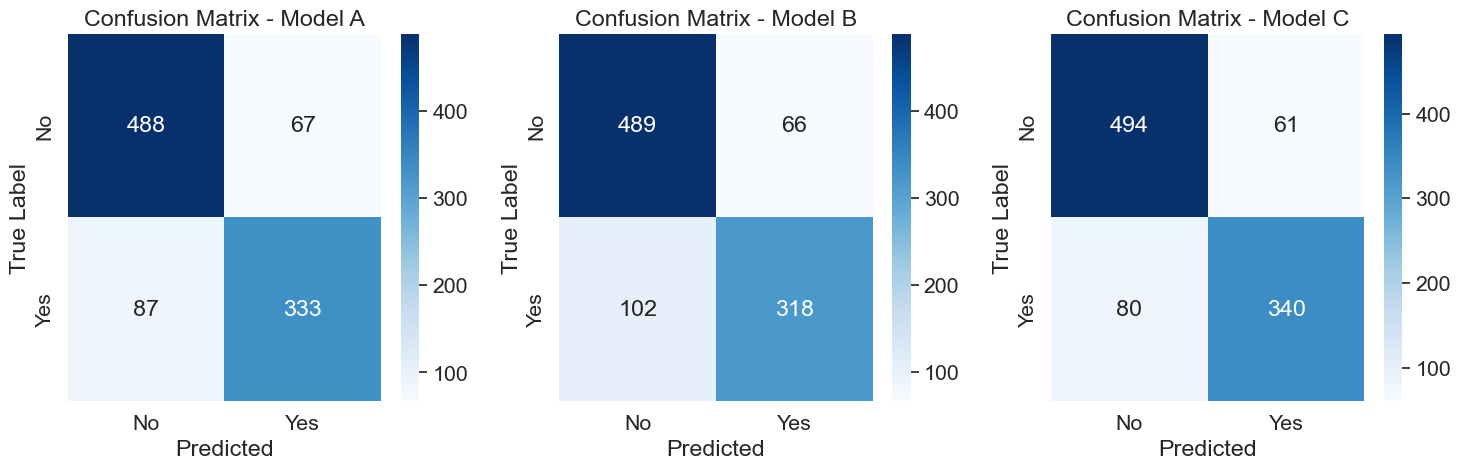

In [12]:
from sklearn.metrics import confusion_matrix
sns.set(font_scale=1.4)
# Confusion matrix for Model A
y_pred_a = opt_xgb_a.predict(data_a['X_test'])
cm_a = confusion_matrix(data_a['y_test'].values, y_pred_a)

# Confusion matrix for Model B
y_pred_b = opt_xgb_b.predict(data_b['X_test'])
cm_b = confusion_matrix(data_b['y_test'].values, y_pred_b)

# Confusion matrix for Model C
y_pred_c = opt_xgb_c.predict(data_c['X_test'])
cm_c = confusion_matrix(data_c['y_test'].values, y_pred_c)

# Plotting the confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(cm_a, annot=True, fmt='d', cmap='Blues', ax=axes[0], yticklabels=['No', 'Yes'], xticklabels=['No', 'Yes'])
axes[0].set_title('Confusion Matrix - Model A')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True Label')

sns.heatmap(cm_b, annot=True, fmt='d', cmap='Blues', ax=axes[1], yticklabels=['No', 'Yes'], xticklabels=['No', 'Yes'])
axes[1].set_title('Confusion Matrix - Model B')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True Label')

sns.heatmap(cm_c, annot=True, fmt='d', cmap='Blues', ax=axes[2], yticklabels=['No', 'Yes'], xticklabels=['No', 'Yes'])
axes[2].set_title('Confusion Matrix - Model C')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True Label')

plt.tight_layout()
plt.show()
